In [1]:
import numpy as np               
import matplotlib.pyplot as plt   
from tqdm import tqdm

#import torch packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torchvision.transforms as tt

if torch.cuda.is_available():
  print('Running on Graphics')
  device=torch.device('cuda:0')
else:
  device=torch.device('cpu')
  print('Running on Processor')

Running on Graphics


In [2]:
train_data = CIFAR10('../../CIFAR/cifar_data/', train=True, download=True,transform=tt.Compose(
    [tt.RandomCrop(32, padding=4),
     tt.RandomHorizontalFlip(),
     tt.ToTensor(),
     tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ]))
test_data = CIFAR10('../../CIFAR/cifar_data/', train=False, download=True,transform=tt.Compose(
    [tt.ToTensor(),
     tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [3]:
def get_acc(yhat, y):
    predictions = torch.argmax(yhat, dim=1)
    total_correct = torch.sum(predictions == y, dtype=torch.float32)
    return total_correct

In [4]:
class block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.c1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.c2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.act = nn.ReLU()
        self.bn1 = nn.BatchNorm2d((in_channels))
        self.bn2 = nn.BatchNorm2d((out_channels))
        if in_channels == out_channels:
            self.id = nn.Identity()
        else:
            self.id = nn.Conv2d(in_channels, out_channels, 1)
        
    def forward(self, x):
        x_res = self.c1(self.act(self.bn1(x)))
        x_res = self.c2(self.act(self.bn2(x_res)))
        return x_res + self.id(x)

class bottleneck(nn.Module):
  def __init__(self):
    super().__init__()
    self.b0 = block(32,32)
    self.b1 = block(32,7)
    self.b2 = block(7,32)
    self.b3 = block(32,32)

  def forward(self, x):
    self.bn = self.b1(self.b0(x))
    x = self.b3(self.b2(self.bn))
    return  x


class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.b1 = block(3,16)
    self.b2 = block(16,32)
    self.pool = nn.MaxPool2d(2)

  def forward(self, x):
    x = self.pool(self.b1(x))
    x = self.pool(self.b2(x))
    return x


class Decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.b1 = block(32,16)
    self.b2 = block(16,3)
    self.u1 = nn.ConvTranspose2d(32,32,2,2)
    self.u2 = nn.ConvTranspose2d(16,16,2,2)
    self.act = nn.Tanh()

  def forward(self, x):
    x = self.b1(self.u1(x))
    x = self.b2(self.u2(x))
    return self.act(x)

class DNA(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = Encoder()
        self.dec = Decoder()
        self.bn1 = bottleneck()
        self.bn2 = bottleneck()
        
    def forward(self, x):
        x = self.enc(x)
        r1 = self.dec(self.bn1(x))
        r2 = self.dec(self.bn2(x))
        return r1, r2
    
class AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = Encoder()
        self.dec = Decoder()
        self.bn = bottleneck()
        
    def forward(self, x):
        x = self.enc(x)
        r1 = self.dec(self.bn(x))
        return r1

In [5]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(3,64,3,padding=1)
        self.r1 = block(64,128)
        self.r2 = block(128,256)
        self.r3 = block(256, 512)
        self.classifier = nn.Sequential(nn.MaxPool2d(4), nn.Flatten(start_dim=1), nn.Linear(512, 10))
        self.act = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        
    def forward(self,x):
        x = self.pool(self.act(self.c1(x)))
        x = self.pool(self.r1(x))
        x = self.pool(self.r2(x))
        x = self.r3(x)
        x = self.classifier(x)
        return x

In [26]:
def gen_PGD(x_nat, y, epsilon, loss_f, models, k=40, a=6.0/255):
    for model in models:
        model.eval()
    y = y.to(device)
    x_nat = x_nat.to(device)
    x = x_nat + (2*epsilon*torch.rand(x_nat.shape) - epsilon).to(device)
    x = torch.clamp(x, -1.0, 1.0)
    for i in range(k):
        x.requires_grad = True
        for model in models:
            model.zero_grad()
        loss = loss_f(x,y)
        loss.backward()
        x = x + a*x.grad.data.sign()
        x = torch.clamp(x, -1.0, 1)
        perturb = torch.clamp(x-x_nat, -epsilon, epsilon)
        x = (x_nat + perturb).detach()
    return x

In [27]:
def gen_FGSM(x, y, epsilon, loss_f, models):
    for model in models:
        model.zero_grad()
    x.requires_grad = True
    loss = loss_f(x,y)
    loss.backward()
    perturbed_x = torch.clamp(x + epsilon*(x.grad.data).sign(), min=-1.0, max=1.0)
    return perturbed_x.detach()

In [28]:
loss_ce = nn.CrossEntropyLoss()
def eval_AE(auto, cls, epsilons, attack_function, label, DN):
    results = []
    if DN:
        loss_f = lambda x,y: loss_ce(cls(auto(x)[0]),y)**2 + loss_ce(cls(auto(x)[1]),y)**2
        a_type = 'DNA (dual)'
    else:
        loss_f = lambda x,y: loss_ce(cls(auto(x)),y)
        a_type = 'AE'
    for epsilon in epsilons:
        total_correct = 0.0
        for x,y in DataLoader(test_data, batch_size=500):
            x = x.to(device)
            y = y.to(device)
            if epsilon != 0.0:
                x = attack_function(x, y, epsilon, loss_f, [auto, cls])
            xhat = auto(x)
            if DN:
                yhat1 = torch.argmax(cls(xhat[0]), dim=1)
                yhat2 = torch.argmax(cls(xhat[1]), dim=1)
                total_correct = total_correct + torch.sum((yhat1==y) | (yhat2==y)).detach().cpu().numpy()

            else:
                yhat1 = torch.argmax(cls(xhat), dim=1)
                total_correct = total_correct + torch.sum(yhat1==y).detach().cpu().numpy()
        acc = total_correct/len(test_data)
        results.append([a_type, label, epsilon, acc])
    if DN:
        loss_f = [lambda x,y: loss_ce(cls(auto(x)[0]),y), lambda x,y: loss_ce(cls(auto(x)[1]),y)]
        a_type = 'DNA (single)'
        for epsilon in epsilons:
            total_correct = 0.0
            for x,y in DataLoader(test_data, batch_size=500):
                x = x.to(device)
                y = y.to(device)
                for i in range(2):
                    if epsilon != 0:
                        x_adv = attack_function(x, y, epsilon, loss2, [auto, cls])
                    else:
                        x_adv = x
                    xhat = auto(x_adv)
                    yhat1 = torch.argmax(cls(xhat[0]), dim=1)
                    yhat2 = torch.argmax(cls(xhat[1]), dim=1)
                    total_correct = total_correct + torch.sum((yhat1==y) | (yhat2==y)).detach().cpu().numpy()
            acc = total_correct/(2*len(test_data))
            results.append([a_type, label, epsilon, acc])
    return results

In [ ]:
#Run the Adversarial Tests
epsilons = [0.0, 4.0/255, 8.0/255, 16.0/255]
dna = AE(in_size, bn_size).to(device)
cls = Classifier().to(device)
dna.load_state_dict(torch.load('models/ae'))
cls.load_state_dict(torch.load('models/cls_ae'))

results = eval_AE(dna, cls, epsilons, gen_FGSM, 'FGSM', DN=False)
results.extend(eval_AE(dna, cls, epsilons, gen_PGD, 'PGD', DN=False))

dna = DNA(in_size, bn_size).to(device)
cls = Classifier().to(device)
dna.load_state_dict(torch.load('models/dna'))
cls.load_state_dict(torch.load('models/cls_dna'))

results.extend(eval_AE(dna, cls, epsilons, gen_FGSM, 'FGSM', DN=True))
results.extend(eval_AE(dna, cls, epsilons, gen_PGD, 'PGD', DN=True)) 

In [ ]:
#save results in dataframe
results_table = pd.DataFrame(results, columns=['Model', 'Attack', r'$\epsilon$', 'Accuracy'])
results_table.columns = ['Model', 'Attack', r'$\epsilon$', 'Accuracy']
results_table['Accuracy'] = results_table['Accuracy']*100
results_table.to_pickle("results.pkl")

Text(0, 0.5, 'Accuracy (%)')

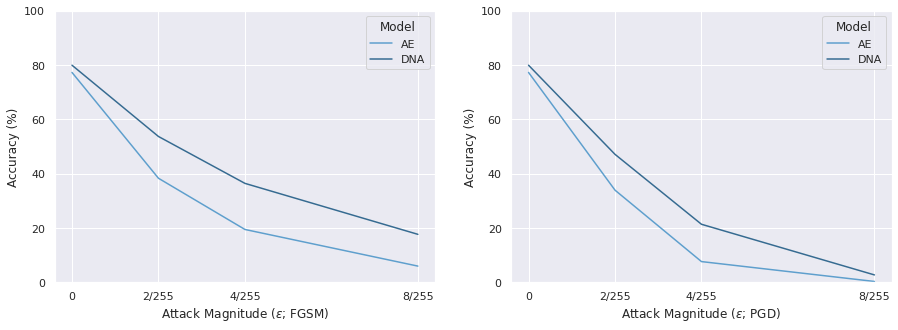

In [99]:
results_table = results_table[results_table.Model != 'DNA (single)']
results_table['Model'] = results_table['Model'].replace('DNA (dual)', 'DNA')

sns.set_theme()
fig, ax = plt.subplots(1,2, figsize=(15,5))

sns.lineplot(ax=ax[0], data=results_table[results_table.Attack == 'FGSM'], x=r'$\epsilon$', y='Accuracy', hue='Model', palette='Blues_d')
ax[0].set_ylim(0,100)
ax[0].set_xlabel(r'Attack Magnitude ($\epsilon$; FGSM)')
ax[0].set_xticks([0.0, 4.0/255, 8.0/255, 16.0/255])
ax[0].set_xticklabels(['0', '2/255', '4/255', '8/255'])
ax[0].set_ylabel('Accuracy (%)')

sns.lineplot(ax=ax[1], data=results_table[results_table.Attack == 'PGD'], x=r'$\epsilon$', y='Accuracy', hue='Model', palette='Blues_d')
ax[1].set_ylim(0,100)
ax[1].set_xlabel(r'Attack Magnitude ($\epsilon$; PGD)')
ax[1].set_xticks([0.0, 4.0/255, 8.0/255, 16.0/255])
ax[1].set_xticklabels(['0', '2/255', '4/255', '8/255'])
ax[1].set_ylabel('Accuracy (%)')

In [100]:
fig.savefig('line_plot.jpg', bbox_inches = 'tight', pad_inches = 0, format='jpg', dpi=600)